In [1]:
import pandas as pd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly_express as px
import plotly.figure_factory as ff
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from sklearn.feature_extraction.text import CountVectorizer

SEED = 42

In [2]:
projects = pd.read_csv("../data/nrao_projects.csv")
projects = projects.set_index('project_code')

In [3]:
line_projects = projects.query('fs_type == "line"')
line_projects.shape

(3628, 12)

In [4]:
measurements = pd.read_csv('../../nrao_measurements.csv')
measurements = measurements.set_index('project_code')
measurements = measurements[measurements.fs_type == 'line']

## Remove outliers from projects and measurements

See 'Identifying_High_Measurement_Projects.ipynb' in 'data' folder

From this notebook, any project with > 26.5 measurements is an outlier

In [5]:
project_measurements = measurements.groupby(measurements.index)\
    .project_title.count()\
        .sort_values(ascending=False)\
        .to_frame()
project_measurements.columns = ['measurement_count']
project_measurements.head()

,measurement_count
project_code,
2017.1.00161.L,289
2017.1.00886.L,283
2021.2.00052.S,265
2023.1.00963.S,253
2022.1.00224.S,188


In [6]:
outliers = project_measurements[project_measurements.measurement_count > 26.5]

In [7]:
measurements = measurements.loc[~measurements.index.isin(outliers.index)]
line_projects = line_projects.loc[~line_projects.index.isin(outliers.index)]

### Use KNN to find $\epsilon$ for DBSCAN
The DBSCAN papers suggest using the elbow method with $k=2*\text{num dimensions}-1$ to find the optimal $\epsilon$

In our case since we're only using 1 dimension we use $k=2$

In [8]:
X = np.array(measurements.med_freq)
X = X.reshape(-1, 1)
neigh = NearestNeighbors(n_neighbors=2)
nbrs = neigh.fit(X)
distances, indices = nbrs.kneighbors(X)

# next, we sort and plot the results
distances = np.sort(distances, axis=0)
distances = distances[:,1]

# Plot
fig = px.scatter(
    distances, 
    title='Distance Curve')
fig.update_xaxes(title_text='Distances')
fig.update_yaxes(title_text='Distance threashold (espsilon)')
fig.show()

In [55]:
#db = DBSCAN(eps=0.145, min_samples=2).fit(list(zip(measurements.med_freq)))
db = DBSCAN(eps=0.05, min_samples=10).fit(list(zip(measurements.med_freq)))

### Summarize and visualize DBSCAN results

In [56]:
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
n_points = len(list(labels))
n_noise = list(labels).count(-1)

print("Estimated number of clusters: %d" % n_clusters)
print("Total number of measurements: %d" % n_points)
print("Estimated number of noise measurements: %d" % n_noise)
print(f"Noise percentage: {round(list(labels).count(-1)/labels.shape[0], 3)}")
print(f'Signal to noise ratio: {1-round(list(labels).count(-1)/labels.shape[0], 3)}')

Estimated number of clusters: 1097
Total number of measurements: 25051
Estimated number of noise measurements: 959
Noise percentage: 0.038
Signal to noise ratio: 0.962


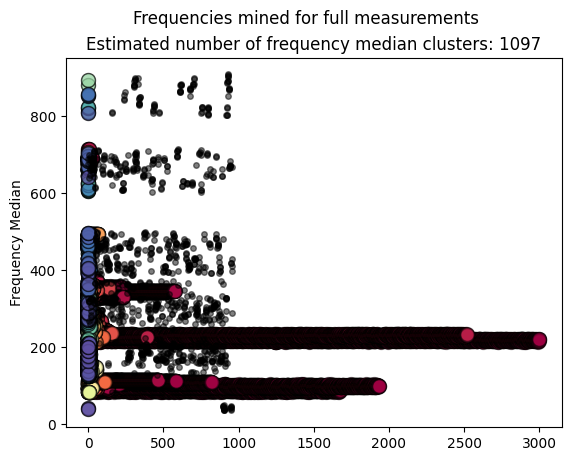

In [57]:
unique_labels = set(labels)
core_samples_mask = np.zeros_like(labels, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True


colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = labels == k

    xy = X[class_member_mask & core_samples_mask]
    plt.plot(
        xy[:],
        #xy[:, 1],
        "o",
        markerfacecolor=tuple(col),
        markeredgecolor="k",
        markersize=10,
        alpha=0.5
    )

    xy = X[class_member_mask & ~core_samples_mask]
    plt.plot(
        xy[:],
        #xy[:, 1],
        "o",
        markerfacecolor=tuple(col),
        markeredgecolor="k",
        markersize=4,
        alpha=0.5
    )

plt.title(f"Estimated number of frequency median clusters: {n_clusters}")
plt.ylabel('Frequency Median')
plt.suptitle(f"Frequencies mined for full measurements")
plt.show()

### Assign labels to measurements for topic and describe clusters
We need to add one since 'noise' not accounted for by a DBSCAN cluster are labeled -1 and we will want to index an array later by cluster label.

In [58]:
measurements['cluster'] = db.labels_ + 1

In [59]:
measurements.groupby('cluster').count().project_title.sort_values(ascending=False).head(20)

cluster
4      3000
55     2521
5      1934
1      1674
0       959
6       822
7       587
14      576
13      514
21      468
64      395
29      234
16      217
3       206
11      204
160     156
131     138
8       135
139     134
12      131
Name: project_title, dtype: int64

In [60]:
measurements.groupby('cluster').count().project_title.describe()

count    1098.000000
mean       22.815118
std       150.602580
min         2.000000
25%         2.000000
50%         4.000000
75%         9.000000
max      3000.000000
Name: project_title, dtype: float64

In [61]:
measurements[measurements.cluster == 2].med_freq.describe()

count    37.000000
mean     91.630541
std       0.123574
min      91.495000
25%      91.515000
50%      91.595000
75%      91.735000
max      91.865000
Name: med_freq, dtype: float64

### Create ground-truth vectors for DBSCAN cluster by project

#### Group by project id

In [62]:
proj_meas = measurements.groupby('project_code').agg({
    'cluster': lambda x: x.to_list()
})

In [63]:
def generate_gt(frame:pd.DataFrame, label_column:str, labs:np.array, normalize=True): 
    '''
    Function that generates ground truth vectors for projects by taking a data frame,
    a string representing the column name that has a list of labels for each measurement,
    and the raw lables from a clustering algorithm

    PARAMETERS:
    
    frame: `pd.DataFrame` indexed by project_code that has a column with list of measurment labels

    label_column: `str` name of column to base ground truth vector off of

    labs: `np.ndarray` of lables generated by clustering algorithm

    normalize: `bool` to normalize vector by sum of values to get probability vector. Defaults to `True`

    OUTPUTS:

    gt_list: `list` of `np.array` ground truth vectors
    '''  
    gt_list = []
    for proj in frame.index.values:
        arr = np.zeros(len(set(list(labs))))
        proj_labs = pd.Series(frame.loc[proj][label_column]).value_counts()
        for idx in proj_labs.index:
            arr[idx] = proj_labs[idx]
        if normalize:
            arr = arr/arr.sum()
        gt_list.append(arr)
    return gt_list

In [64]:
ground_truth = generate_gt(proj_meas, 'cluster', db.labels_, normalize=True)
len(ground_truth)

3284

In [65]:
len(ground_truth[0])

1098